# Malaria Cell Classification using CNN

The dataset comprises of segmented cells from the thin blood smear slide images from the Malaria Screener research activity conducted by Lister Hill National Center for Biomedical Communications (LHNCBC), part of National Library of Medicine (NLM). The dataset has been manually annotated by experts into two categories:
- Parasitic
- Uninfected

The dataset can be found in the URL: https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html

We will try to use a Dense Convolution Neural Network algorithm to classify the images into parasitized or uninfected. \
The original dataset contains 27,558 images evenly balanced in two categories. However, due to high computation resource unavailability we will randomly sample some 2000 images from each class for training and test. Avid researchers with high computational resources are encouraged to perform training on the complete dataset.

In [2]:
# Import the required libararies
import numpy as np
np.random.seed(365) # set a random seed for replication
import matplotlib.pyplot as plt

import os
import shutil
import glob
import random

import cv2
from PIL import Image
from tensorflow import keras
os.environ['KERAS_BACKEND'] = 'tensorflow'

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [3]:
cd /content/drive/MyDrive/Colab Notebooks/Malaria

/content/drive/MyDrive/Colab Notebooks/Malaria


### Random Sampling of Images

In [4]:
# Sample some records for training
num_img = 2000
sampled_parasitized = random.sample(glob.glob("./cell_images/Parasitized/*.png"), num_img)

for f in enumerate(sampled_parasitized, 1):
    dest = os.path.join(os.getcwd() + "/data/Parasitized/")
    if not os.path.exists(dest):
        os.makedirs(dest)
    shutil.copy(f[1], dest)

sampled_parasitized = random.sample(glob.glob("./cell_images/Uninfected/*.png"), num_img)

for f in enumerate(sampled_parasitized, 1):
    dest = os.path.join(os.getcwd() + "/data/Uninfected/")
    if not os.path.exists(dest):
        os.makedirs(dest)
    shutil.copy(f[1], dest)

In [5]:
print("Parasitized Data: ", len(glob.glob("./data/Parasitized/*.png")))
print("Uninfected Data: ", len(glob.glob("./data/Uninfected/*.png")))

2000
2000


In [6]:
# Iterate through all images in Parasitized folder, resize to 64 x 64
# Then save as numpy array with name 'dataset'
# Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

image_directory = 'data/'
SIZE = 64
dataset = [] 
label = []  

In [7]:
# Iterate through all images in the sampled Parasitized folder
# Since the images are a various sized, resize them all to 64 x 64
# Then save into the same numpy array 'dataset' but with label 0

parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):    
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

In [8]:
# Iterate through all images in the sampled Uninfected folder
# Since the images are a various sized, resize them all to 64 x 64
# Then save into the same numpy array 'dataset' but with label 1

uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

## Model

In [9]:
# Input Images change to (SIZE, SIZE, 3)
INPUT_SHAPE = (SIZE, SIZE, 3)   
inp = keras.layers.Input(shape=INPUT_SHAPE)

In [10]:
# Create Model

# Convolutional Neural Network
conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

# Flatten the matrix to get it ready for dense.
flat = keras.layers.Flatten()(drop2)  

# Dense Fully Connected Network
hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0     

In [11]:
# Compile the model with Adam optimizer and categorical crossentropy loss
# https://www.machinecurve.com/index.php/2019/10/22/how-to-use-binary-categorical-crossentropy-with-keras/

model.compile(optimizer='adam',
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [12]:
# Split the data into training and test with 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

In [13]:
# Define Callbacks to save the best model and not just the last one
if not os.path.exists('./models'):
    os.makedirs('models/')
model_path = './models/malaria.h5'

callbacks = keras.callbacks.ModelCheckpoint(filepath=model_path, mode='max', monitor='val_accuracy', verbose=2, save_best_only=True)

### Training

In [14]:
#Fit the model
history = model.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 100,      #Changed to 3 from 50 for testing purposes.
                         validation_split = 0.1,
                         shuffle = False,
                         callbacks=[callbacks]
                     )

Epoch 1/100
45/45 [==============================] - 4s 31ms/step - loss: 0.8812 - accuracy: 0.6017 - val_loss: 1.6500 - val_accuracy: 0.5844

Epoch 00001: val_accuracy improved from -inf to 0.58438, saving model to ./models/malaria.h5
Epoch 2/100
45/45 [==============================] - 1s 21ms/step - loss: 0.6256 - accuracy: 0.6910 - val_loss: 1.0389 - val_accuracy: 0.6438

Epoch 00002: val_accuracy improved from 0.58438 to 0.64375, saving model to ./models/malaria.h5
Epoch 3/100
45/45 [==============================] - 1s 22ms/step - loss: 0.4783 - accuracy: 0.7806 - val_loss: 2.2027 - val_accuracy: 0.4719

Epoch 00003: val_accuracy did not improve from 0.64375
Epoch 4/100
45/45 [==============================] - 1s 21ms/step - loss: 0.3900 - accuracy: 0.8333 - val_loss: 0.9393 - val_accuracy: 0.7094

Epoch 00004: val_accuracy improved from 0.64375 to 0.70938, saving model to ./models/malaria.h5
Epoch 5/100
45/45 [==============================] - 1s 21ms/step - loss: 0.3237 - accur

### Accuracy and Loss

In [15]:
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

25/25 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.8900
Test_Accuracy: 89.00%


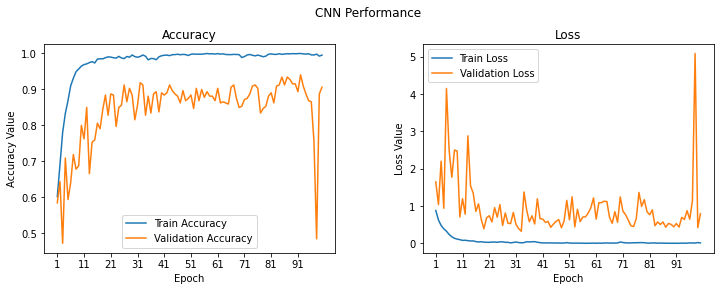

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Save Model

In [17]:
#Save the model
model.save('models/malaria_cnn.h5')